# 03. 理解图神经网络的消息传递机制

图神经网络（Graph Neural Network，简称GNN）是一种用于处理图结构数据的深度学习模型。


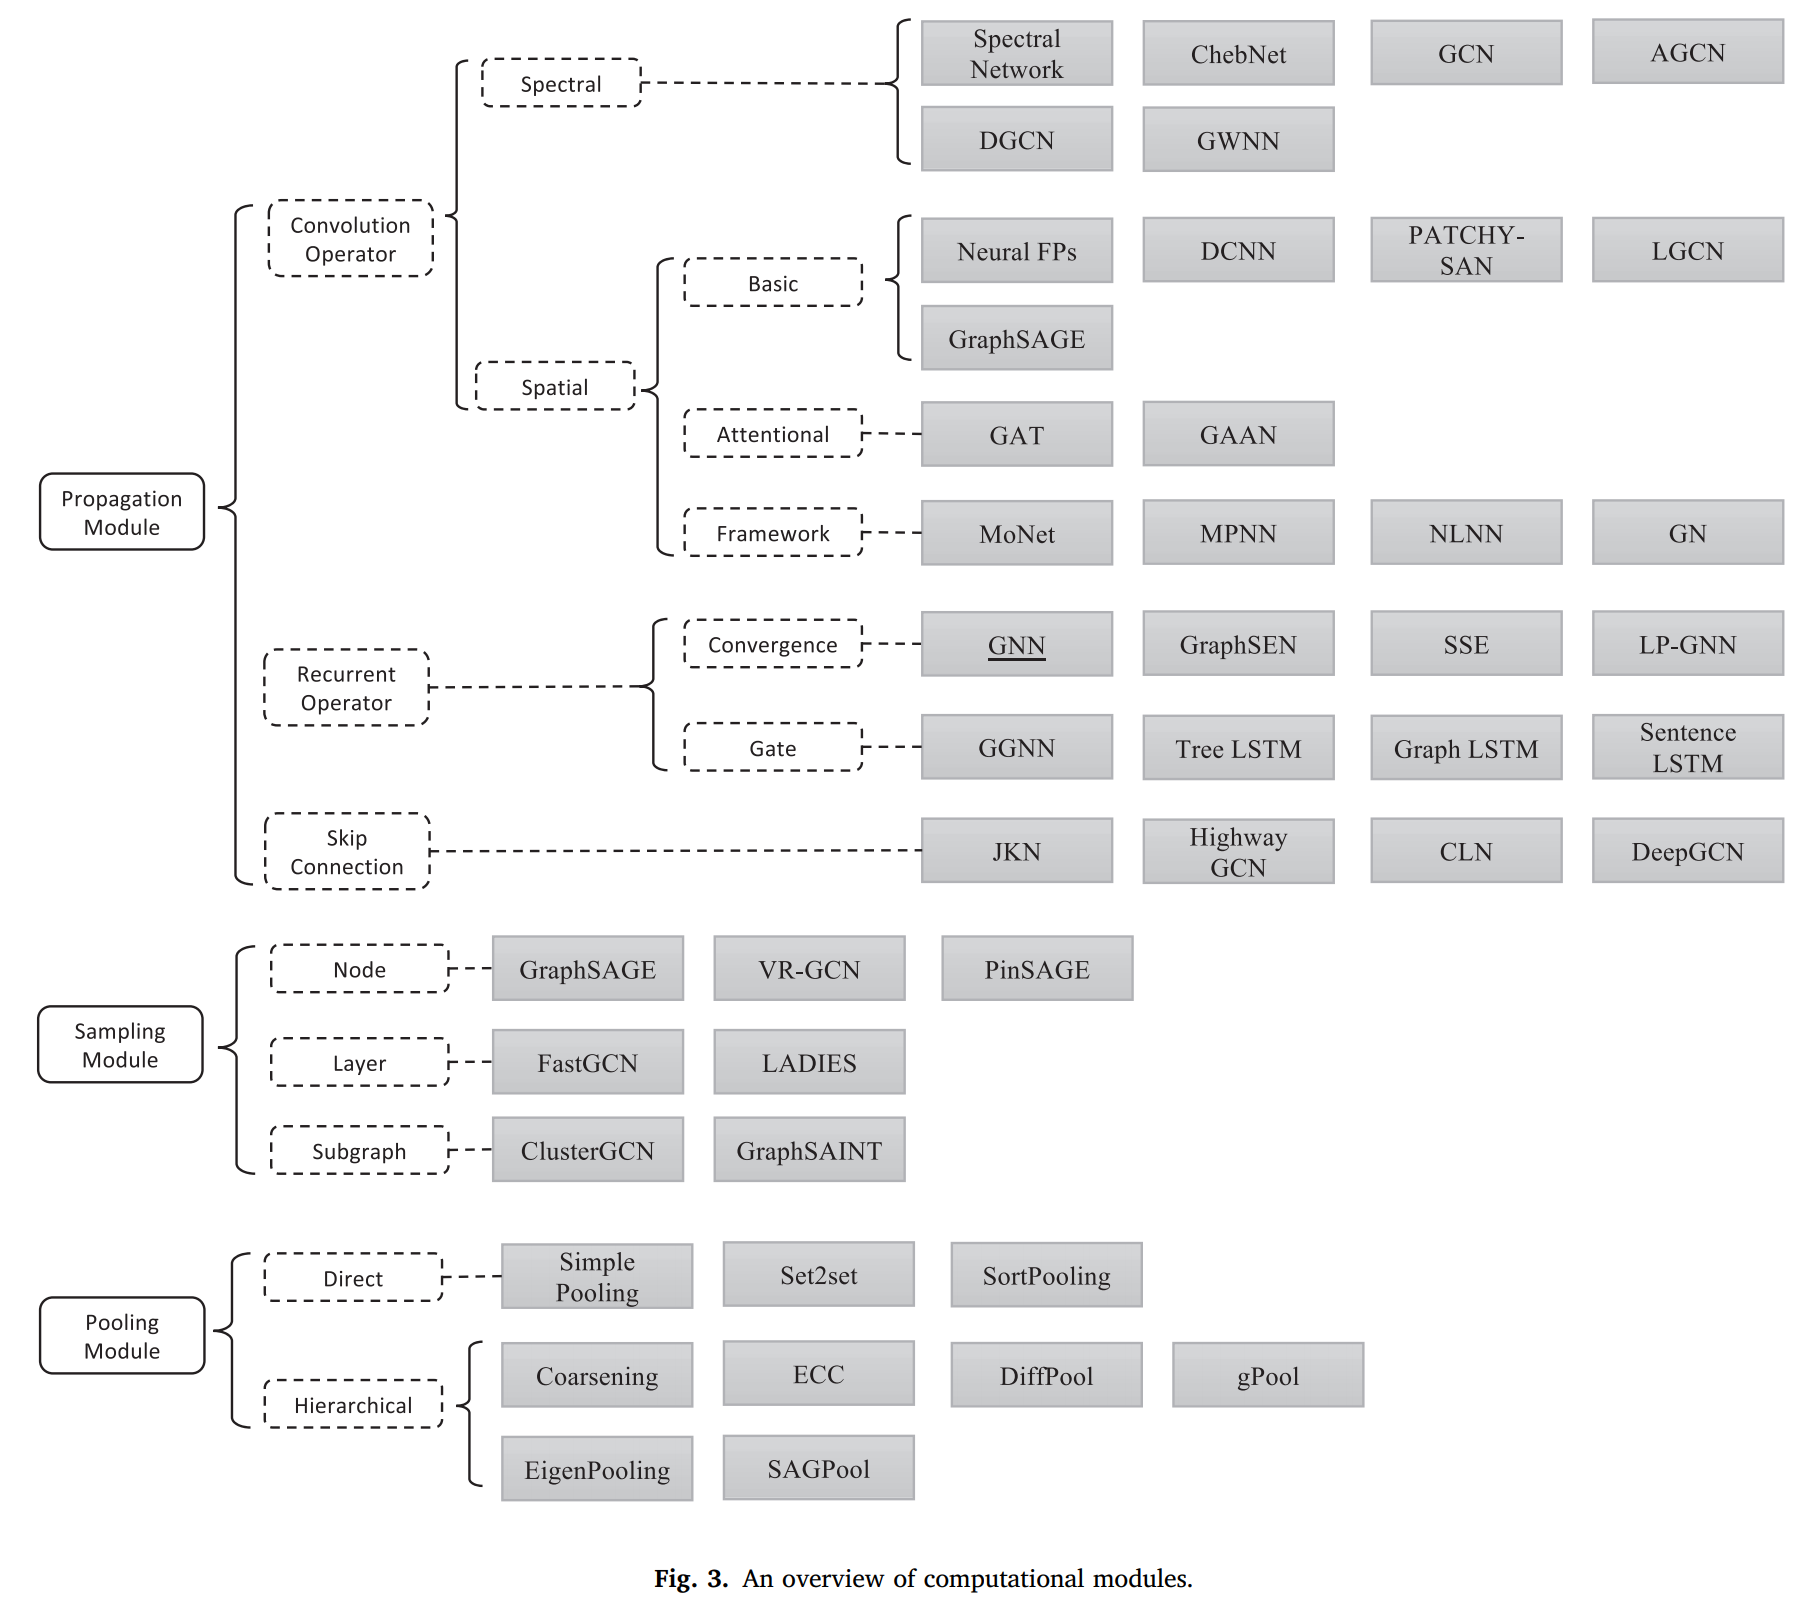

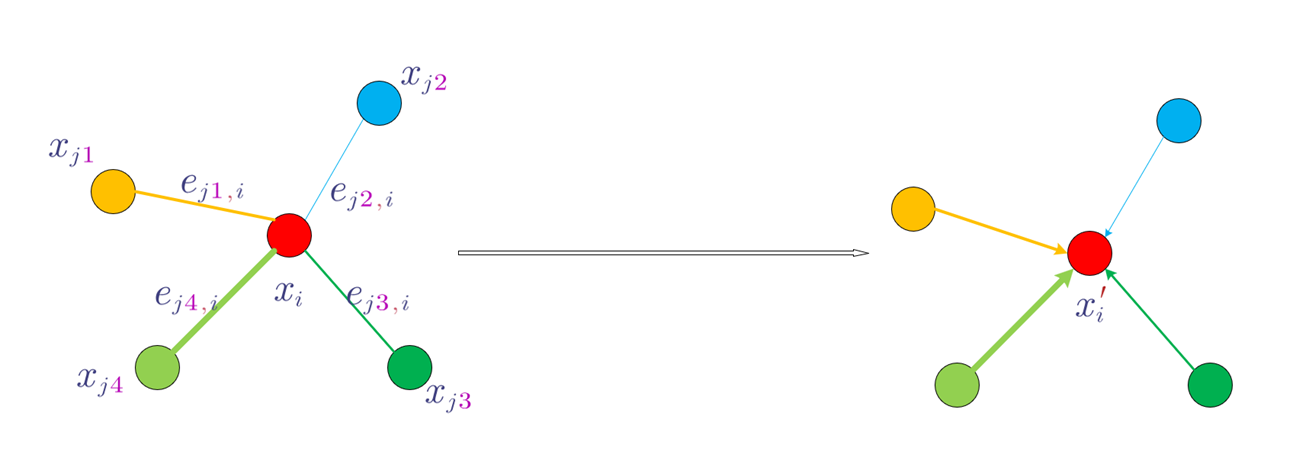


$$
\mathbf{x}'_i = \gamma_{\Theta} \left( \mathbf{x}_i, \bigoplus_{j \in \mathcal{N}(i)} \phi_{\Theta}(\mathbf{x}_i, \mathbf{x}_j, \mathbf{e}_{j,i}) \right)
$$



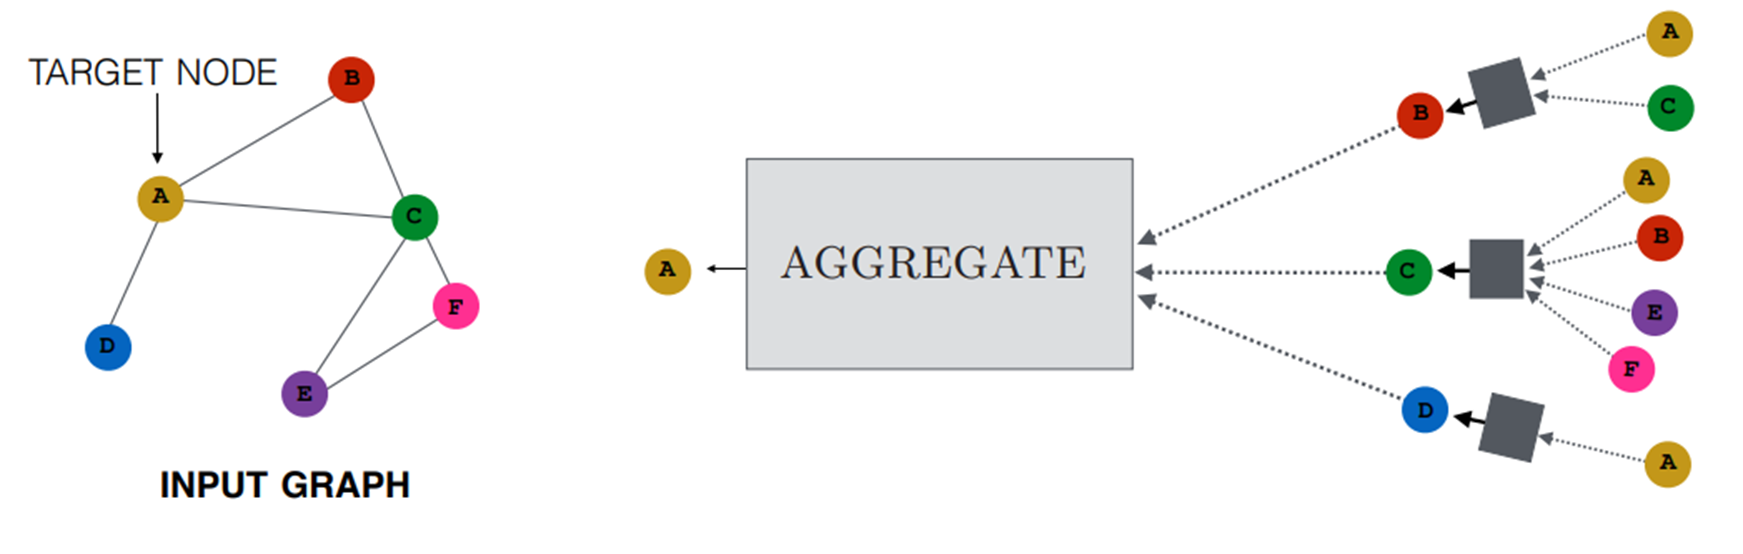

$$
\begin{align*}
\mathbf{h}_u^{(k + 1)}&= \text{UPDATE}^{(k)}\left(\mathbf{h}_u^{(k)},\text{AGGREGATE}^{(k)}(\{\mathbf{h}_v^{(k)},\forall v\in\mathcal{N}(u)\})\right)\\
&= \text{UPDATE}^{(k)}\left(\mathbf{h}_u^{(k)},\mathbf{m}_{\mathcal{N}(u)}^{(k)}\right),
\end{align*}
$$


## 消息传递机制

[PyG：Creating Message Passing Networks](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)

### 构建一个有向图

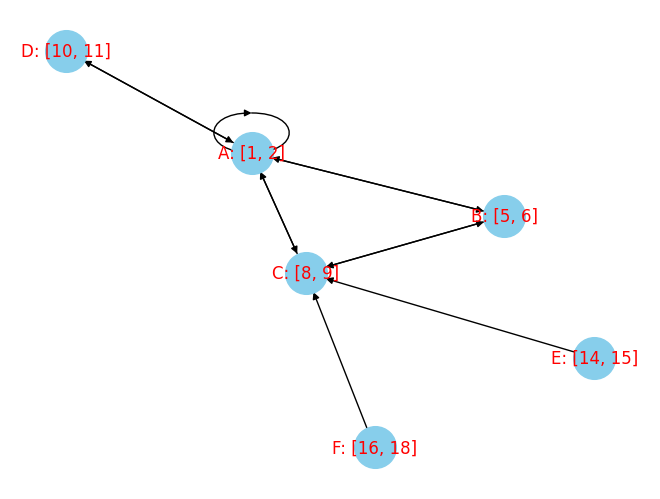

In [7]:
%matplotlib inline
# 上图为例构建一个有向图
import networkx as nx
import matplotlib.pyplot as plt


G = nx.DiGraph()

# 创建节点
nodes = ['A', 'B', 'C', 'D', 'E', 'F']
G.add_nodes_from(nodes)

# 添加节点属性
nodes_attributes = {'A': [1, 2], 'B': [5, 6], 'C': [8, 9], 'D': [10, 11], 'E': [14, 15], 'F': [16, 18]}
nx.set_node_attributes(G, nodes_attributes, 'embeddings')

# 创建边
edges = [('A', 'A'), ('A', 'B'), ('B', 'A'), ('A', 'C'), ('C', 'A'), ('A', 'D'), ('D', 'A'), ('C', 'B'), ('B', 'C'), ('E', 'C'), ('F', 'C')]
G.add_edges_from(edges)

# 获取节点标签
node_labels = nx.get_node_attributes(G, 'embeddings')

pos = nx.spring_layout(G)

# 绘制图
nx.draw(G, pos, with_labels=False, node_size=900, node_color='skyblue', font_size=15, font_weight='bold', font_color='black')

# 绘制节点标签
nx.draw_networkx_labels(G, pos, font_color='red', labels={k: f'{k}: {v}' for k, v in node_labels.items()})

plt.show()

### 使用add聚合方法进行消息传递（只考虑邻居节点）

In [15]:
import torch
from torch_geometric.nn import MessagePassing

# 设定节点特征张量
x = torch.tensor([[1, 2],
                  [5, 6],
                  [8, 9],
                  [10, 11],
                  [14, 15],
                  [16, 18]])

# 设定边索引张量
edge_index = torch.tensor([[0, 0, 1, 0, 2, 0, 3, 1, 2, 4, 5],
                           [0, 1, 0, 2, 0, 3, 0, 2, 1, 2, 2]], dtype=torch.long)


class MessagePassingLayer(MessagePassing):
    def __init__(self):
        super(MessagePassingLayer, self).__init__(aggr='add')

    def forward(self, x, edge_index):
        # propagate()内部调用message()函数，并将x_j传入给message()函数
        return self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j):
        # 中心节点特征: x_i has shape [E, in_channels](和索引顺序有关)
        # 邻居节点特征: x_j has shape [E, in_channels]
        for idx in range(len(x_i)):
            print(f"Edge {idx}: {edge_index[0][idx].item()} -> {edge_index[1][idx].item()}")
            print(f"Source node (x_j) features: {x_j[idx].tolist()}")
            print(f"Target node (x_i) features: {x_i[idx].tolist()}\n")
        return x_j
    
    def aggregate(self, inputs, index):
        # 在聚合之前打印
        print("\nAggregation step:")
        for idx in torch.unique(index):
            mask = index == idx
            messages = inputs[mask]
            print(f"\nNode {idx.item()} receives messages:")
            print(f"Messages: {messages.tolist()}")
            print(f"Sum of messages: {messages.sum(0).tolist()}")
        
        return super().aggregate(inputs, index)
    


MessagePassingLayer = MessagePassingLayer()
output = MessagePassingLayer(x, edge_index)
print(output)

Edge 0: 0 -> 0
Source node (x_j) features: [1, 2]
Target node (x_i) features: [1, 2]

Edge 1: 0 -> 1
Source node (x_j) features: [1, 2]
Target node (x_i) features: [5, 6]

Edge 2: 1 -> 0
Source node (x_j) features: [5, 6]
Target node (x_i) features: [1, 2]

Edge 3: 0 -> 2
Source node (x_j) features: [1, 2]
Target node (x_i) features: [8, 9]

Edge 4: 2 -> 0
Source node (x_j) features: [8, 9]
Target node (x_i) features: [1, 2]

Edge 5: 0 -> 3
Source node (x_j) features: [1, 2]
Target node (x_i) features: [10, 11]

Edge 6: 3 -> 0
Source node (x_j) features: [10, 11]
Target node (x_i) features: [1, 2]

Edge 7: 1 -> 2
Source node (x_j) features: [5, 6]
Target node (x_i) features: [8, 9]

Edge 8: 2 -> 1
Source node (x_j) features: [8, 9]
Target node (x_i) features: [5, 6]

Edge 9: 4 -> 2
Source node (x_j) features: [14, 15]
Target node (x_i) features: [8, 9]

Edge 10: 5 -> 2
Source node (x_j) features: [16, 18]
Target node (x_i) features: [8, 9]


Aggregation step:

Node 0 receives messages:

### 使用mean聚合方法进行消息传递 （只考虑邻居节点）



In [16]:
import torch
from torch_geometric.nn import MessagePassing

# 设定节点特征张量
x = torch.tensor([[1, 2],
                  [5, 6],
                  [8, 9],
                  [10, 11],
                  [14, 15],
                  [16, 18]])

# 设定边索引张量
edge_index = torch.tensor([[0, 0, 1, 0, 2, 0, 3, 1, 2, 4, 5],
                           [0, 1, 0, 2, 0, 3, 0, 2, 1, 2, 2]], dtype=torch.long)


class MessagePassingLayer(MessagePassing):
    def __init__(self):
        super(MessagePassingLayer, self).__init__(aggr='mean')

    def forward(self, x, edge_index):
        # propagate()内部调用message()函数，并将x_j传入给message()函数
        return self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j):
        # 中心节点特征: x_i has shape [E, in_channels](和索引顺序有关)
        # 邻居节点特征: x_j has shape [E, in_channels]
        for idx in range(len(x_i)):
            print(f"Edge {idx}: {edge_index[0][idx].item()} -> {edge_index[1][idx].item()}")
            print(f"Source node (x_j) features: {x_j[idx].tolist()}")
            print(f"Target node (x_i) features: {x_i[idx].tolist()}\n")
        return x_j
    
    def aggregate(self, inputs, index):
        # 在聚合之前打印
        print("\nAggregation step:")
        for idx in torch.unique(index):
            mask = index == idx
            messages = inputs[mask]
            print(f"\nNode {idx.item()} receives messages:")
            print(f"Messages: {messages.tolist()}")
            print(f"Sum of messages: {messages.sum(0).tolist()}")
        
        return super().aggregate(inputs, index)
    


MessagePassingLayer = MessagePassingLayer()
output = MessagePassingLayer(x, edge_index)
print(output)

Edge 0: 0 -> 0
Source node (x_j) features: [1, 2]
Target node (x_i) features: [1, 2]

Edge 1: 0 -> 1
Source node (x_j) features: [1, 2]
Target node (x_i) features: [5, 6]

Edge 2: 1 -> 0
Source node (x_j) features: [5, 6]
Target node (x_i) features: [1, 2]

Edge 3: 0 -> 2
Source node (x_j) features: [1, 2]
Target node (x_i) features: [8, 9]

Edge 4: 2 -> 0
Source node (x_j) features: [8, 9]
Target node (x_i) features: [1, 2]

Edge 5: 0 -> 3
Source node (x_j) features: [1, 2]
Target node (x_i) features: [10, 11]

Edge 6: 3 -> 0
Source node (x_j) features: [10, 11]
Target node (x_i) features: [1, 2]

Edge 7: 1 -> 2
Source node (x_j) features: [5, 6]
Target node (x_i) features: [8, 9]

Edge 8: 2 -> 1
Source node (x_j) features: [8, 9]
Target node (x_i) features: [5, 6]

Edge 9: 4 -> 2
Source node (x_j) features: [14, 15]
Target node (x_i) features: [8, 9]

Edge 10: 5 -> 2
Source node (x_j) features: [16, 18]
Target node (x_i) features: [8, 9]


Aggregation step:

Node 0 receives messages:

### 使用max聚合方法进行消息传递 （只考虑邻居节点）

In [17]:
import torch
from torch_geometric.nn import MessagePassing

# 设定节点特征张量
x = torch.tensor([[1, 2],
                  [5, 6],
                  [8, 9],
                  [10, 11],
                  [14, 15],
                  [16, 18]])

# 设定边索引张量
edge_index = torch.tensor([[0, 0, 1, 0, 2, 0, 3, 1, 2, 4, 5],
                           [0, 1, 0, 2, 0, 3, 0, 2, 1, 2, 2]], dtype=torch.long)


class MessagePassingLayer(MessagePassing):
    def __init__(self):
        super(MessagePassingLayer, self).__init__(aggr='max')

    def forward(self, x, edge_index):
        # propagate()内部调用message()函数，并将x_j传入给message()函数
        return self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j):
        # 中心节点特征: x_i has shape [E, in_channels](和索引顺序有关)
        # 邻居节点特征: x_j has shape [E, in_channels]
        for idx in range(len(x_i)):
            print(f"Edge {idx}: {edge_index[0][idx].item()} -> {edge_index[1][idx].item()}")
            print(f"Source node (x_j) features: {x_j[idx].tolist()}")
            print(f"Target node (x_i) features: {x_i[idx].tolist()}\n")
        return x_j
    
    def aggregate(self, inputs, index):
        # 在聚合之前打印
        print("\nAggregation step:")
        for idx in torch.unique(index):
            mask = index == idx
            messages = inputs[mask]
            print(f"\nNode {idx.item()} receives messages:")
            print(f"Messages: {messages.tolist()}")
            print(f"Sum of messages: {messages.sum(0).tolist()}")
        
        return super().aggregate(inputs, index)
    


MessagePassingLayer = MessagePassingLayer()
output = MessagePassingLayer(x, edge_index)
print(output)

Edge 0: 0 -> 0
Source node (x_j) features: [1, 2]
Target node (x_i) features: [1, 2]

Edge 1: 0 -> 1
Source node (x_j) features: [1, 2]
Target node (x_i) features: [5, 6]

Edge 2: 1 -> 0
Source node (x_j) features: [5, 6]
Target node (x_i) features: [1, 2]

Edge 3: 0 -> 2
Source node (x_j) features: [1, 2]
Target node (x_i) features: [8, 9]

Edge 4: 2 -> 0
Source node (x_j) features: [8, 9]
Target node (x_i) features: [1, 2]

Edge 5: 0 -> 3
Source node (x_j) features: [1, 2]
Target node (x_i) features: [10, 11]

Edge 6: 3 -> 0
Source node (x_j) features: [10, 11]
Target node (x_i) features: [1, 2]

Edge 7: 1 -> 2
Source node (x_j) features: [5, 6]
Target node (x_i) features: [8, 9]

Edge 8: 2 -> 1
Source node (x_j) features: [8, 9]
Target node (x_i) features: [5, 6]

Edge 9: 4 -> 2
Source node (x_j) features: [14, 15]
Target node (x_i) features: [8, 9]

Edge 10: 5 -> 2
Source node (x_j) features: [16, 18]
Target node (x_i) features: [8, 9]


Aggregation step:

Node 0 receives messages:

### 使用add聚合方法进行消息传递 （考虑中心节点+邻居节点）


In [19]:
import torch
from torch_geometric.nn import MessagePassing

# 设定节点特征张量
x = torch.tensor([[1, 2],
                  [5, 6],
                  [8, 9],
                  [10, 11],
                  [14, 15],
                  [16, 18]])

# 设定边索引张量
edge_index = torch.tensor([[0, 0, 1, 0, 2, 0, 3, 1, 2, 4, 5],
                           [0, 1, 0, 2, 0, 3, 0, 2, 1, 2, 2]], dtype=torch.long)


class MessagePassingLayer(MessagePassing):
    def __init__(self):
        super(MessagePassingLayer, self).__init__(aggr='add')

    def forward(self, x, edge_index):
        # propagate()内部调用message()函数，并将x_j传入给message()函数
        return self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j, edge_index):
        # 中心节点特征: x_i has shape [E, in_channels](和索引顺序有关)
        # 邻居节点特征: x_j has shape [E, in_channels]
        for idx in range(len(x_i)):
            print(f"Edge {idx}: {edge_index[0][idx].item()} -> {edge_index[1][idx].item()}")
            print(f"Source node (x_j) features: {x_j[idx].tolist()}")
            print(f"Target node (x_i) features: {x_i[idx].tolist()}")
            print(f"Combined message: {(x_j[idx] + x_i[idx]).tolist()}")
        return x_j + x_i
    
    def aggregate(self, inputs, index):
        # 在聚合之前打印
        print("\nAggregation step:")
        for idx in torch.unique(index):
            mask = index == idx
            messages = inputs[mask]
            print(f"\nNode {idx.item()} receives messages:")
            print(f"Individual messages: {messages.tolist()}")
            print(f"Aggregated message (sum): {messages.sum(0).tolist()}")
        
        return super().aggregate(inputs, index)
    


model = MessagePassingLayer()
output = model(x, edge_index)
print(output)

Edge 0: 0 -> 0
Source node (x_j) features: [1, 2]
Target node (x_i) features: [1, 2]
Combined message: [2, 4]
Edge 1: 0 -> 1
Source node (x_j) features: [1, 2]
Target node (x_i) features: [5, 6]
Combined message: [6, 8]
Edge 2: 1 -> 0
Source node (x_j) features: [5, 6]
Target node (x_i) features: [1, 2]
Combined message: [6, 8]
Edge 3: 0 -> 2
Source node (x_j) features: [1, 2]
Target node (x_i) features: [8, 9]
Combined message: [9, 11]
Edge 4: 2 -> 0
Source node (x_j) features: [8, 9]
Target node (x_i) features: [1, 2]
Combined message: [9, 11]
Edge 5: 0 -> 3
Source node (x_j) features: [1, 2]
Target node (x_i) features: [10, 11]
Combined message: [11, 13]
Edge 6: 3 -> 0
Source node (x_j) features: [10, 11]
Target node (x_i) features: [1, 2]
Combined message: [11, 13]
Edge 7: 1 -> 2
Source node (x_j) features: [5, 6]
Target node (x_i) features: [8, 9]
Combined message: [13, 15]
Edge 8: 2 -> 1
Source node (x_j) features: [8, 9]
Target node (x_i) features: [5, 6]
Combined message: [13, 